# Simulação: Data Drift, Model Drift e Target Drift

Etapa 1: Preparação dos dados

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
directory_path = "./docker/log/"

In [3]:
df = pd.read_csv(f'{directory_path}/loan_default.csv')
df = df.drop(['ID', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges'], axis=1).dropna(axis=0)

In [4]:
X = df[['occupancy_type', 'co_applicant_credit_type', 'Credit_Score', 'LTV', 'loan_purpose', 
        'dtir1', 'property_value', 'submission_of_application', 'approv_in_adv', 'income']]
y = df['Status']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=42)

Etapa 2: Carregamento do modelo

In [6]:
model_path = "./docker/model/"

In [7]:
with open(f'{model_path}/default_propensity_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [8]:
y_test_pred = model.predict(X_test)

Etapa 3: Desenvolvimento das simulações

In [9]:
# Função para adicionar data drift
def simulate_data_drift(X, column, drift_type='noise', **kwargs):
    """
    Adiciona data drift a uma coluna específica.
    
    Parâmetros:
    X (DataFrame): DataFrame original.
    column (str): Nome da coluna para adicionar o drift.
    drift_type (str): Tipo de drift ('noise' ou 'shift').
    **kwargs: Argumentos adicionais dependendo do tipo de drift.
    
    Retorna:
    DataFrame: DataFrame com drift adicionado.
    """
    new_X = X.copy()
    if drift_type == 'noise':
        noise = np.random.normal(loc=kwargs.get('mean', 0), scale=kwargs.get('std', 1), size=X[column].shape)
        new_X[column] += noise

    elif drift_type == 'shift':
        new_X[column] += kwargs.get('shift', 1)
    return new_X

Nesse trecho, desenvolvemos uma função chamada simulate_data_drift, cujo propósito é introduzir artificialmente alterações nos dados para simular o "data drift". O data drift ocorre quando a distribuição dos dados muda ao longo do tempo, o que pode afetar o desempenho dos modelos de aprendizado de máquina. 

A função é projetada para ser flexível e capaz de manipular diferentes tipos de drift:

  -  Ruído (Noise): Ao especificar drift_type='noise', a função adiciona ruído gaussiano aos valores de uma coluna específica. Isso é feito gerando amostras de uma distribuição normal com média e desvio padrão especificados pelo usuário através dos argumentos mean e std. O ruído gaussiano é uma escolha comum para simulação de data drift, pois é uma forma de introduzir variação aleatória que pode representar muitos tipos de variação natural ou sistêmica nos dados.

  -  Deslocamento (Shift): Alternativamente, ao especificar drift_type='shift', a função desloca os valores da coluna escolhida por uma quantidade fixa, que é especificada pelo argumento shift. Este tipo de drift pode simular uma mudança mais sistemática nos dados, como uma alteração nas políticas de crédito que afetam todas as pontuações de crédito por uma quantidade constante.

In [10]:
def simulate_model_drift(model, X_test, y_test, max_drift=1.0, step=0.1):
    """
    Simula a degradação da acurácia do modelo introduzindo data drift nos dados de teste
    e calculando a acurácia das previsões do modelo com os dados alterados.
    
    Parâmetros:
    model: Modelo treinado.
    X_test (DataFrame): DataFrame de entrada para o modelo.
    y_test (array): Valores reais do target para calcular a acurácia.
    max_drift (float): Máximo ruído a ser simulado.
    step (float): Passo para aumentar o ruído.
    
    Retorna:
    (numpy.ndarray, list): Tupla contendo os valores de drift e as acurácias correspondentes.
    """
    drift_values = np.arange(0, max_drift + step, step)
    accuracies = []

    for drift_amount in drift_values:
        X_test_drift = simulate_data_drift(X_test, 'Credit_Score', drift_type='noise', mean=0, std=drift_amount)
        
        y_pred_drift = model.predict(X_test_drift)
        
        accuracy = accuracy_score(y_test, y_pred_drift)
        accuracies.append(accuracy)

    return drift_values, accuracies

A função simulate_model_drift serve para avaliar a robustez de um modelo de aprendizado de máquina frente a alterações no conjunto de dados de teste, o que é essencial para entender a estabilidade do modelo em condições de mudança. A função permite simular como o desempenho do modelo, em termos de acurácia, é afetado à medida que introduzimos gradativamente mais ruído — uma representação de data drift — nos dados de teste.

A estrutura da função está definida para realizar uma série de experimentos em que o data drift é incrementado de forma controlada. Ela aceita os seguintes parâmetros:

  -  model: o modelo previamente treinado que será testado.
  -  X_test: os dados de teste originais, nos quais o drift será aplicado.
  -  y_test: os rótulos reais correspondentes a X_test, usados para calcular a acurácia.
  -  max_drift: o nível máximo de ruído que será simulado.
  -  step: o incremento no nível de ruído para cada iteração do experimento.

No corpo da função, criamos uma série de valores de drift que vão de 0 (sem ruído) até o max_drift especificado, incrementados de acordo com o step. Para cada um desses valores de drift, aplicamos a função simulate_data_drift na coluna 'Credit_Score' dos dados de teste, introduzindo variação nos dados que o modelo irá prever.

Depois de aplicar o drift, usamos o modelo para fazer previsões com o conjunto de teste modificado e calculamos a acurácia dessas previsões em comparação com os verdadeiros rótulos de y_test. Isso nos dá uma visão clara de como a acurácia do modelo decai à medida que o data drift aumenta.

Os resultados são retornados como uma tupla de arrays: um contendo os níveis de drift aplicados e outro com as acurácias correspondentes. Esses resultados podem ser usados para visualizar a relação entre o nível de ruído e a performance do modelo, geralmente esperamos ver uma curva de degradação onde a acurácia diminui à medida que o ruído aumenta.

Etapa 4: Simulações

In [11]:
# Simulando Data Drift
X_test_drift = simulate_data_drift(X_test, 'Credit_Score', drift_type='noise', mean=0, std=983)

In [12]:
# Simulando Model Drift
drift_values, accuracies = simulate_model_drift(model, X_test, y_test, max_drift=1.0, step=0.1)

In [13]:
# Simulando Target Drift
y_test_drift = y_test.copy()
y_test_drift[y_test_drift == 0] = np.random.choice([0, 1], size=(y_test_drift == 0).sum(), p=[0.7, 0.3])
y_test_drift[y_test_drift == 1] = np.random.choice([0, 1], size=(y_test_drift == 1).sum(), p=[0.3, 0.7])

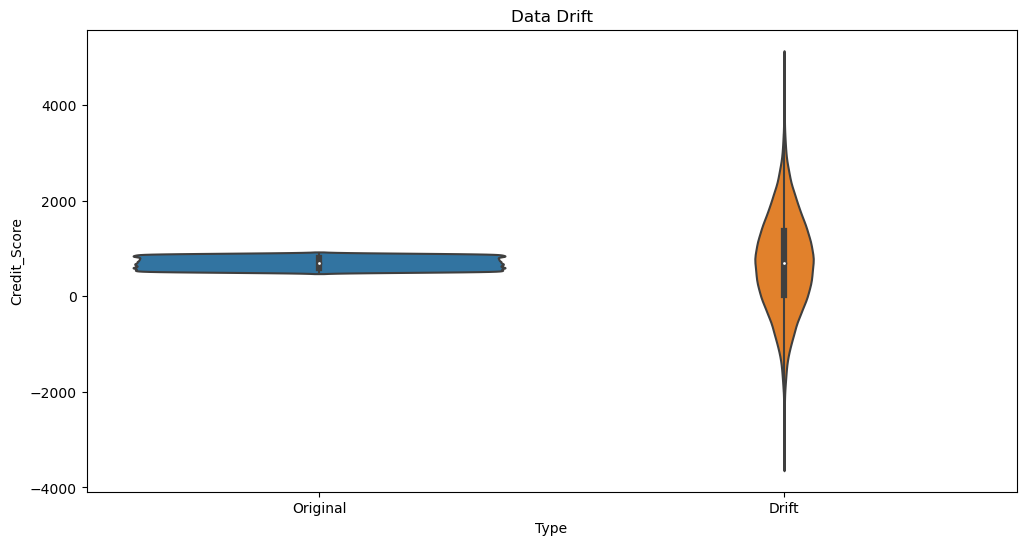

In [14]:
# Função para plotar data drift com gráfico de violino
def plot_violin_drift(X_original, X_drift, column, title):
    data = pd.concat([X_original[[column]], X_drift[[column]]], axis=0)
    data['Type'] = ['Original']*len(X_original) + ['Drift']*len(X_drift)
    
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Type', y=column, data=data)
    plt.title(title)
    plt.show()

plot_violin_drift(X_test, X_test_drift, 'Credit_Score', 'Data Drift')

In [15]:
X_test['Credit_Score'].describe()

count    48211.000000
mean       699.313497
std        115.770295
min        500.000000
25%        599.000000
50%        699.000000
75%        800.000000
max        900.000000
Name: Credit_Score, dtype: float64

In [16]:
X_test_drift['Credit_Score'].describe()

count    48211.000000
mean       697.400890
std        991.021608
min      -3421.126511
25%         25.552295
50%        701.597559
75%       1369.347457
max       4907.140680
Name: Credit_Score, dtype: float64

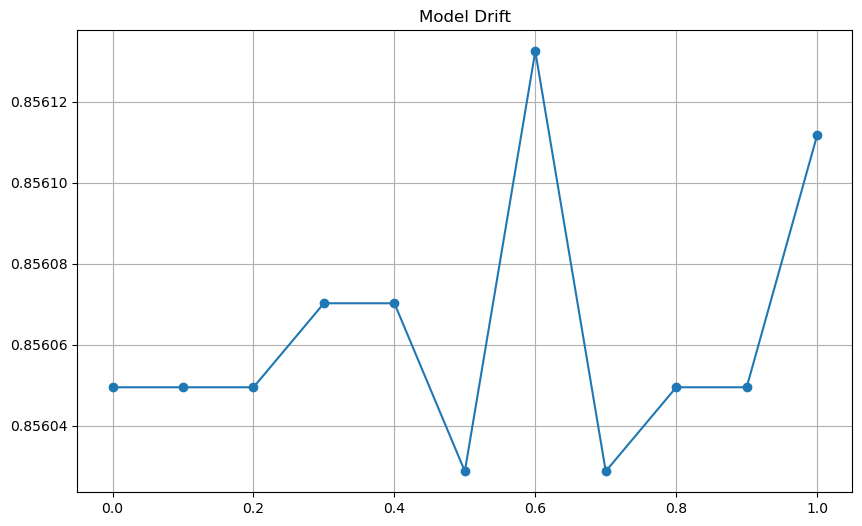

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(drift_values, accuracies, marker='o')
plt.title('Model Drift')
plt.grid(True)
plt.show()

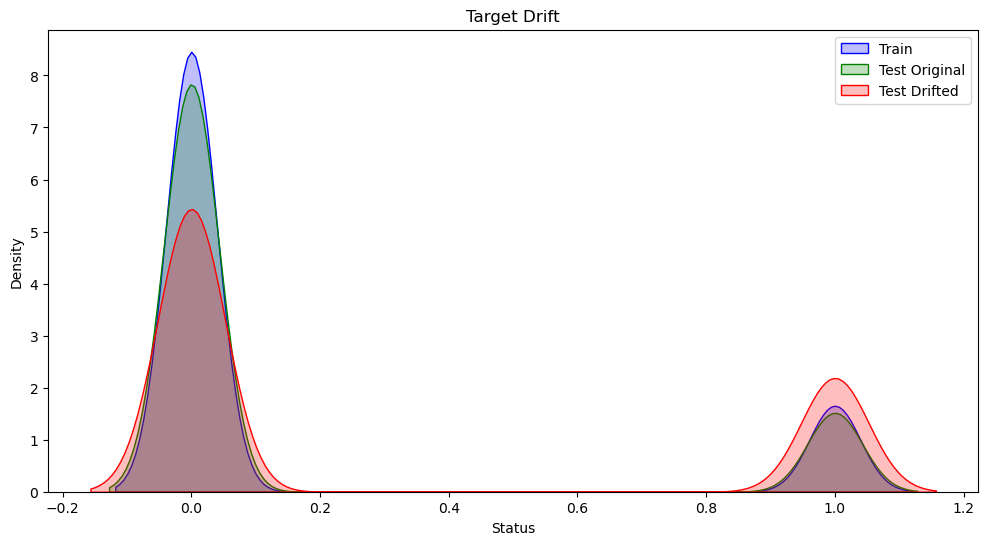

In [18]:
# Função para plotar target drift com gráficos de densidade
def plot_density_target_drift(y_train, y_test, y_test_drifted, title):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(y_train, color='blue', label='Train', fill=True)
    sns.kdeplot(y_test, color='green', label='Test Original', fill=True)
    sns.kdeplot(y_test_drifted, color='red', label='Test Drifted', fill=True)
    plt.title(title)
    plt.legend()
    plt.show()

plot_density_target_drift(y_train, y_test, y_test_drift, 'Target Drift')